In [1]:
%run spatial_analysis_load.ipynb

working dir: /opt/dssg-hot/notebooks/shirley
Test commercial vs. private classification; following # should be zero: 0
Test commerical vs. private classification by num of trips; following # should be zero: 0
Test one-time use frequency classification; following # should be zero: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [2]:
fips_grouped = dfnow.groupby('fips')

In [3]:
fips_avg_dist = fips_grouped.mean()['Dist btwn entry & exit loop']

In [4]:
fips_sov_grouped = dfnow[dfnow['is_hov']==0].groupby('fips')

In [5]:
fips_avg_toll_wohov = fips_sov_grouped.mean()['toll']

In [6]:
cbgs_join = cbgs_acs.merge(fips_avg_toll_wohov, on='fips')
cbgs_join.rename(columns={'toll':'avg_toll_wohov'}, inplace=True)

In [7]:
cbgs_join = cbgs_join.merge(fips_avg_dist, on='fips')
cbgs_join.rename(columns={'Dist btwn entry & exit loop':'avg_dist'}, inplace=True)

In [9]:
# - For some applications below, need cbgs_join as a pandas dataframe, rather than a gpd dataframe;
# will also need centroids of block groups

cbgs_join_df = pd.DataFrame(cbgs_join.drop(columns='geometry'))
cbgs_join_df['lon'] = cbgs_join['geometry'].centroid.x
cbgs_join_df['lat'] = cbgs_join['geometry'].centroid.y
#print(type(cbgs_join_df))
#print(cbgs_join_df.dtypes)

# Play with altair

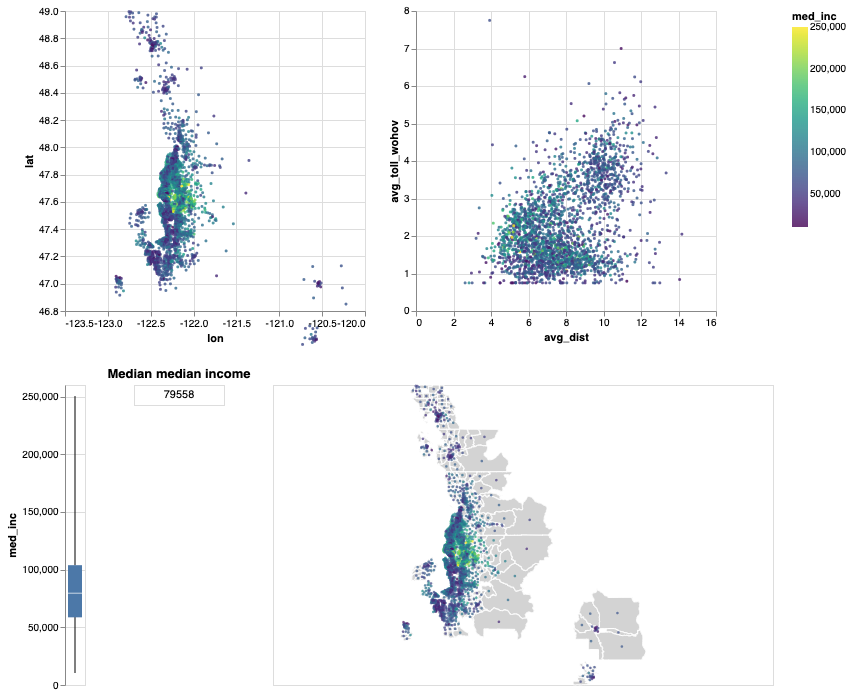

In [10]:
# https://stackoverflow.com/questions/56428206/altair-linked-map-with-scatter-plot
# https://github.com/altair-viz/altair/issues/588 - see responses by iliatimofeev

interval = alt.selection_interval()
med_inc_color = alt.Color('med_inc:Q', scale=alt.Scale(scheme='viridis'))

# - Scatterplots
base = alt.Chart(cbgs_join_df).mark_circle(opacity=0.8,size=8).encode(
    color=alt.condition(interval, med_inc_color, alt.value('lightgray'), legend=alt.Legend(orient='left', title='%white')),
    tooltip='med_inc'
    ).properties(
        selection=interval,
        width=300
    )

scatter = base.encode(alt.X('lon', scale=alt.Scale(domain=[-123.5, -120])), y=alt.Y('lat', scale=alt.Scale(domain=[46.9, 49]))) | base.encode(x='avg_dist', y='avg_toll_wohov')

# - Boxplot
boxplot = alt.Chart(cbgs_join_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('med_inc', scale=alt.Scale(domain=[0, 250000]))
).transform_filter(
    interval
)

# - Background map
cbgs_join_json = alt.InlineData(values = cbgs_join.to_json(), #geopandas to geojson string
                       # root object type is "FeatureCollection" but we need its features
                       format = alt.DataFormat(property='features',type='json')) 
background = alt.Chart(cbgs_join_json).mark_geoshape(
    #color='med_inc:Q',
    fill='lightgray',
    stroke='white'
    ).properties(
        width=500,
        height=300
    ).project('mercator')

# - Points at centroids of block groups
points = alt.Chart(cbgs_join_df).mark_circle(size=6).encode(
    longitude='lon',
    latitude='lat',
    #tooltip=['name', 'city', 'state'],
    color=alt.condition(interval, med_inc_color, alt.value('lightgray'))
    )

# - Text
table = alt.Chart(cbgs_join_df).mark_text().encode(
    text='median(med_inc)'
).transform_filter(
    interval
).properties(
    title='Median median income'
)

scatter & (boxplot | table | (background+points))

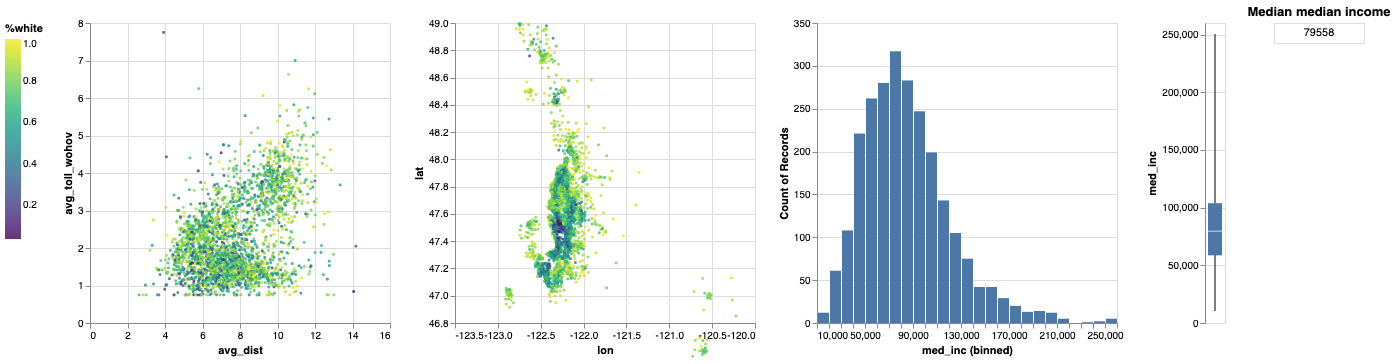

In [11]:
interval = alt.selection_interval()

base = alt.Chart(cbgs_join_df).mark_circle(
    opacity=0.8,
    size=8
).encode(
    color=alt.condition(interval, 'race_nonhisp_white', alt.value('lightgray'), scale=alt.Scale(scheme='viridis'), legend=alt.Legend(orient='left', title='%white')),
    tooltip='fips'
).properties(
    selection=interval,
    width=300
)

hist = alt.Chart(cbgs_join_df).mark_bar().encode(
    x=alt.X('med_inc', bin=alt.Bin(maxbins=30)),
    y='count()'
).transform_filter(
    interval
).properties(
    width=300
)

table = alt.Chart(cbgs_join_df).mark_text().encode(
    text='median(med_inc)'
).transform_filter(
    interval
).properties(
    title='Median median income'
)

boxplot = alt.Chart(cbgs_join_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('med_inc', scale=alt.Scale(domain=[0, 250000]))
).transform_filter(
    interval
)

scatter = base.encode(x='avg_dist', y='avg_toll_wohov') | base.encode(alt.X('lon', scale=alt.Scale(domain=[-123.5, -120])), y=alt.Y('lat', scale=alt.Scale(domain=[46.9, 49])))

scatter | hist | boxplot | table